In [3]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import glob
import time
import math
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

# Import models and config
import config
from utils import evalutils, plotutils
from models import vanilla,vgg16

# Set random seed for consistency
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

# Displays all outputs of a cell (not just last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

TensorFlow version: 2.2.0
Keras version: 2.3.0-tf


In [9]:
def smooth_curve(points, factor=0.8):
    
# """
#   Helper function to help smooth accuracy/loss plots using an exponential
#   moving average of the loss and accuracy values. 
#   """
    smoothed_points = []
    for point in points:
        
        if smoothed_points:
            
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            
            smoothed_points.append(point)
    return smoothed_points

def get_plots(history, smooth=False):   
#       """
#   Helper function to plot training/validation accuracy/loss.
#   @param history - Keras model history 
#   @param smooth - Boolean for whether to smooth plots or not
#   """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
  
    if smooth == True:
        
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    acc = plt.figure()
    acc.plot(epochs, acc, 'bo', label='Training acc')
    acc.plot(epochs, val_acc,'b', label='Validation acc')
    acc.title('Training and validation accuracy')
    acc.legend()
    
    loss = plt.figure()
    loss.plot(epochs, loss, 'bo', label='Training loss')
    loss.plot(epochs, val_loss, 'b', label='Validation loss')
    loss.title('Training and validation loss')
    loss.legend()

    plt.show()

def get_metrics(model, generator, steps, target_names=[]):
    
    """
  Function to print out confusion matrix and classification report.
  """
    target_names = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
    abbreviations = ['BM', 'BR', 'LB', 'H']
  
  # Get predictions for data
    y_pred = model.predict_generator(generator=generator, steps=steps)
    y_pred = np.argmax(a=y_pred, axis=1)
  
  # Get confusion matix
    cnf_mat = confusion_matrix(y_true=generator.classes, y_pred=y_pred)
    fig, ax = plt.subplots(1)
    ax = sns.heatmap(cnf_mat, ax=ax, cmap=plt.cm.Blues, annot=True, fmt='g')
    ax.set_xticklabels(abbreviations)
    ax.set_yticklabels(abbreviations)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()
  
  # Get classification report
    
    print('Classification Report')
    print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=target_names))

In [10]:
work_dir = '.'
data_dir = os.path.join(work_dir, 'data')

# Original data (before split)
black_measles_dir = os.path.join(data_dir, 'black_measles')
black_rot_dir = os.path.join(data_dir, 'black_rot')
leaf_blight_dir = os.path.join(data_dir, 'leaf_blight')
healthy_dir = os.path.join(data_dir, 'healthy')

# Train/Validation/Test
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Training data by class
train_black_measles_dir = os.path.join(train_dir, 'black_measles')
train_black_rot_dir = os.path.join(train_dir, 'black_rot')
train_leaf_blight_dir = os.path.join(train_dir, 'leaf_blight')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Validation data by class
validation_black_measles_dir = os.path.join(validation_dir, 'black_measles')
validation_black_rot_dir = os.path.join(validation_dir, 'black_rot')
validation_leaf_blight_dir = os.path.join(validation_dir, 'leaf_blight')
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Test data by class
test_black_measles_dir = os.path.join(test_dir, 'black_measles')
test_black_rot_dir = os.path.join(test_dir, 'black_rot')
test_leaf_blight_dir = os.path.join(test_dir, 'leaf_blight')
test_healthy_dir = os.path.join(test_dir, 'healthy')

In [11]:
num_black_measles = len(os.listdir(black_measles_dir))
num_black_rot = len(os.listdir(black_rot_dir))
num_leaf_blight = len(os.listdir(leaf_blight_dir))
num_healthy = len(os.listdir(healthy_dir))
total_images = num_black_measles + num_black_rot + num_leaf_blight + num_healthy
                                   
print('Total Images: {}'.format(total_images))
print('black_measles class has {} images'.format(num_black_measles))
print('black_rot class has {} images'.format(num_black_rot))
print('leaf_blight class has {} images'.format(num_leaf_blight))
print('healthy class has {} images'.format(num_healthy))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '.\\data\\black_measles'

In [12]:

num_train_black_measles = len(os.listdir(train_black_measles_dir))
num_train_black_rot = len(os.listdir(train_black_rot_dir))
num_train_leaf_blight = len(os.listdir(train_leaf_blight_dir))
num_train_healthy = len(os.listdir(train_healthy_dir))

num_val_black_measles = len(os.listdir(validation_black_measles_dir))
num_val_black_rot = len(os.listdir(validation_black_rot_dir))
num_val_leaf_blight = len(os.listdir(validation_leaf_blight_dir))
num_val_healthy = len(os.listdir(validation_healthy_dir))

num_test_black_measles = len(os.listdir(test_black_measles_dir))
num_test_black_rot = len(os.listdir(test_black_rot_dir))
num_test_leaf_blight = len(os.listdir(test_leaf_blight_dir))
num_test_healthy = len(os.listdir(test_healthy_dir))

total_train = num_train_black_measles + num_train_black_rot + \
                num_train_leaf_blight + num_train_healthy
total_val = num_val_black_measles + num_val_black_rot + \
              num_val_leaf_blight + num_val_healthy
total_test = num_test_black_measles + num_test_black_rot + \
              num_test_leaf_blight + num_test_healthy

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(config.img_height, config.img_width),
                    color_mode='rgb',
                    batch_size=config.batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=42)

validation_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(config.img_height, config.img_width),
                          color_mode='rgb',
                          batch_size=config.batch_size,
                          class_mode='categorical')

valtest_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(config.img_height, config.img_width),
                          color_mode='rgb',
                          batch_size=1,
                          class_mode='categorical')

# Test data generator - no augmentation (to be used at very end)
test_gen = test_datagen.flow_from_directory(
                test_dir,
                target_size=(config.img_height, config.img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 2603 images belonging to 4 classes.
Found 648 images belonging to 4 classes.
Found 648 images belonging to 4 classes.
Found 811 images belonging to 4 classes.


In [14]:
data = {'train': train_generator,
        'num_train': total_train,
        'val': validation_generator,
        'num_val': total_val,
        'test': test_gen,
        'num_test': total_test,
        'valtest': test_gen}

In [67]:
saved_model = './trained_models/vanilla.h5'
model = vanilla.VanillaCNN()
# model.evaluate(saved_model, data['test'], data['num_test'], name=None)
model.predict('./healthy0.jpg')lo

AttributeError: 'VanillaCNN' object has no attribute 'predict'

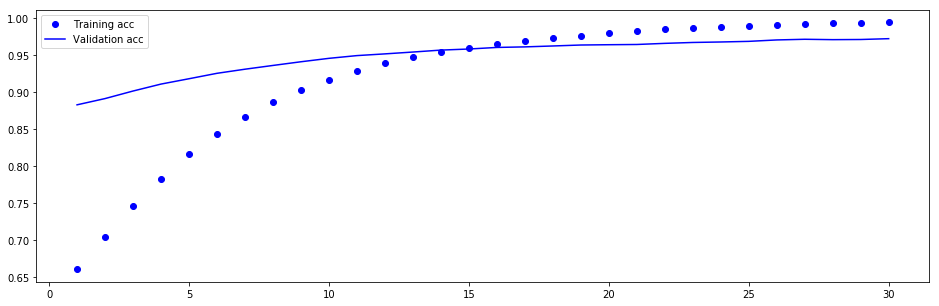

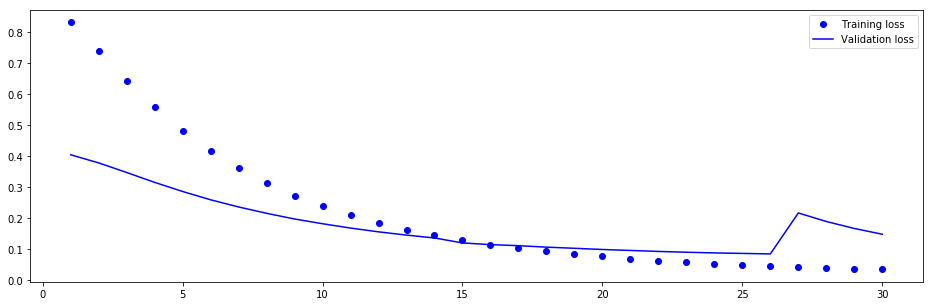

In [60]:
import matplotlib.pyplot as plt

def get_plots():
    
    smooth=True
    
    acc=[0.6604,0.8775,0.9152,0.9319,0.9459,0.9545,0.9607,0.9642,0.9658,0.9728,0.9767,0.9809,0.979,0.9833,0.9833,0.9856,0.9868,0.9876,0.9891,0.9930,0.9942,0.9934,0.9918,0.9949,0.9938,0.9981,0.9973,0.9949,0.9969,0.9969]
  
    val_acc=[0.8828,0.925,0.9422,0.9484,0.9469,0.9547,0.9531,0.9563,0.9609,0.9641,0.9641,0.9609,0.9641,0.9672,0.9641,0.9688,0.9641,0.9672,0.9688,0.9656,0.9656,0.9719,0.9719,0.9703,0.9719,0.9781,0.975,0.9688,0.9719,0.9766]
 
    loss=[0.8322,0.3657,0.2651,0.2119,0.1816,0.1555,0.1353,0.1229,0.1121,0.1023,0.0917,0.0834,0.0785,0.0722,0.0641,0.0589,0.0585,0.0565,0.0482,0.0438,0.041,0.0377,0.0386,0.035,0.0326,0.0298,0.028,0.0295,0.0263,0.0247]

    val_loss=[0.4046,0.274,0.2234,0.1881,0.1683,0.1517,0.1439,0.1338,0.1237,0.1209,0.1119,0.1071,0.1032,0.0991,0.056,0.0926,0.0976,0.0874,0.088,0.0832,0.0836,0.0798,0.0798,0.079,0.0798,0.0778,0.746,0.0784,0.077,0.0735]

    epochs = [i for i in range(1, len(acc)+1)]
  
    if smooth == True:
        
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

#     print(len(acc))
#     print(len(epochs))

    acc=np.array(acc)
    val_acc=np.array(val_acc)
    loss=np.array(loss)
    val_loss=np.array(val_loss)
    
    acc1 = plt.figure().gca()
#     acc1.title('Training and validation accuracy')
    acc1.plot(epochs, acc, 'bo', label='Training acc')
    acc1.plot(epochs, val_acc,'b', label='Validation acc')
    
    acc1.legend()
    
#     acc.show()
    
    loss1 = plt.figure().gca()
    loss1.plot(epochs, loss, 'bo', label='Training loss')
    loss1.plot(epochs, val_loss, 'b', label='Validation loss')
#     loss1.title('Training and validation loss')
    loss1.legend()

    plt.show()
    
    
get_plots()

In [29]:

saved_model = './trained_models/vgg16.h5'
model = vgg16.VGG16()
get_metrics(model)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

TypeError: get_metrics() missing 2 required positional arguments: 'generator' and 'steps'

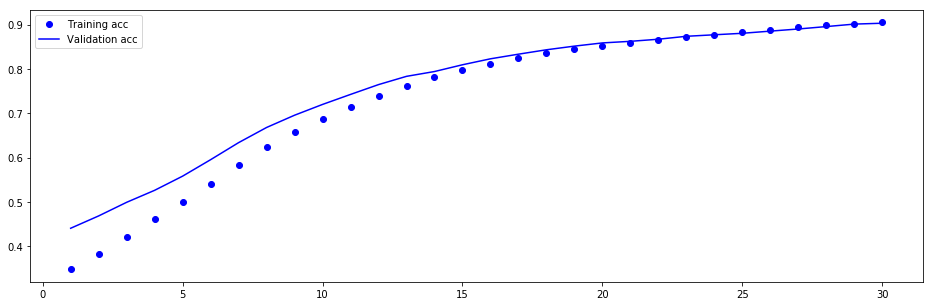

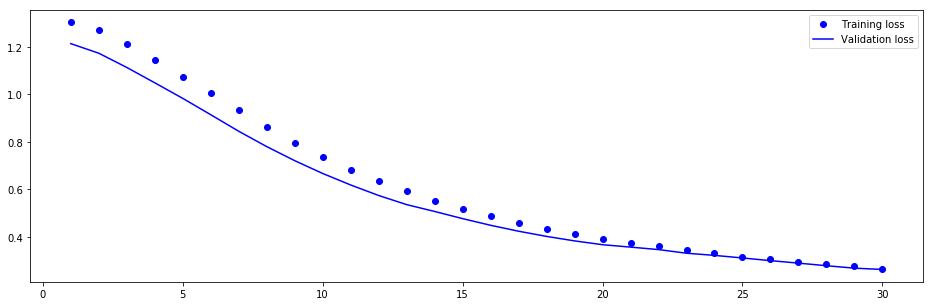

In [61]:
import matplotlib.pyplot as plt

def get_plots():
    
    smooth=True
    
#     acc=[0.3477,0.5189,0.576,0.9319,0.9459,0.9545,0.9607,0.9642,0.9658,0.9728,0.9767,0.9809,0.9790,0.9833,0.9833,0.9856,0.9868,0.9876,0.9891,0.9930,0.9942,0.9934,0.9918,0.9949,0.9938,0.9981,0.9973,0.9949,0.9969,0.9969]
  
    val_acc=[0.8828,0.925,0.9422,0.9484,0.9469,0.9547,0.9531,0.9563,0.9609,0.9641,0.9641,0.9609,0.9641,0.9672,0.9641,0.9688,0.9641,0.9672,0.9688,0.9656,0.9656,0.9719,0.9719,0.9703,0.9719,0.9781,0.975,0.9688,0.9719,0.9766]
 
    acc=[0.3477, 0.5189, 0.5760, 0.6188, 0.6593, 0.7067, 0.7546, 0.7787, 0.8020, 0.8040, 0.8199, 0.8405, 0.8475, 0.8588, 0.8627, 0.8666, 0.8767, 0.8841, 0.8775, 0.8806, 0.8895, 0.8946, 0.8954, 0.8989, 0.9082, 0.9098, 0.9164, 0.9129, 0.9117, 0.9218]
    loss=[ 1.3036, 1.1378, 0.9729, 0.8804, 0.7982, 0.7222, 0.6470, 0.5888, 0.5293, 0.4979, 0.4667, 0.4383, 0.4207, 0.3906, 0.3838, 0.3672, 0.3453, 0.3305, 0.3281, 0.3181, 0.3065, 0.2985, 0.2823, 0.2782, 0.2615, 0.2572, 0.2484, 0.2482, 0.2390, 0.2261]

    val_acc=[0.4406,0.5797,0.6219,0.6344,0.6859,0.7437,0.7875,0.8047,0.8062,0.8172,0.8328,0.8531,0.8578,0.8375,0.8703,0.8766,0.8750,0.8828,0.8844,0.8875,0.8766,0.8859,0.9000,0.8906,0.8938,0.9047,0.9094,0.9172,0.9234,0.9109]
    val_loss=[1.2140, 1.0124, 0.8743, 0.7908, 0.7212, 0.6398, 0.5663, 0.5221, 0.4846, 0.4517, 0.4252, 0.3975, 0.3825, 0.3924, 0.3564, 0.3371, 0.3243, 0.3153, 0.3078, 0.3032, 0.3168, 0.3053, 0.2707, 0.2857, 0.2684, 0.2551, 0.2482, 0.2353, 0.2277, 0.2416]
    epochs = [i for i in range(1, len(acc)+1)]
  
    if smooth == True:
        
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

#     print(len(acc))
#     print(len(epochs))

    acc=np.array(acc)
    val_acc=np.array(val_acc)
    loss=np.array(loss)
    val_loss=np.array(val_loss)
    
    acc1 = plt.figure().gca()
#     acc1.title('Training and validation accuracy')
    acc1.plot(epochs, acc, 'bo', label='Training acc')
    acc1.plot(epochs, val_acc,'b', label='Validation acc')
    
    acc1.legend()
    
#     acc.show()
    
    loss1 = plt.figure().gca()
    loss1.plot(epochs, loss, 'bo', label='Training loss')
    loss1.plot(epochs, val_loss, 'b', label='Validation loss')
#     loss1.title('Training and validation loss')
    loss1.legend()

    plt.show()
    
    
get_plots()

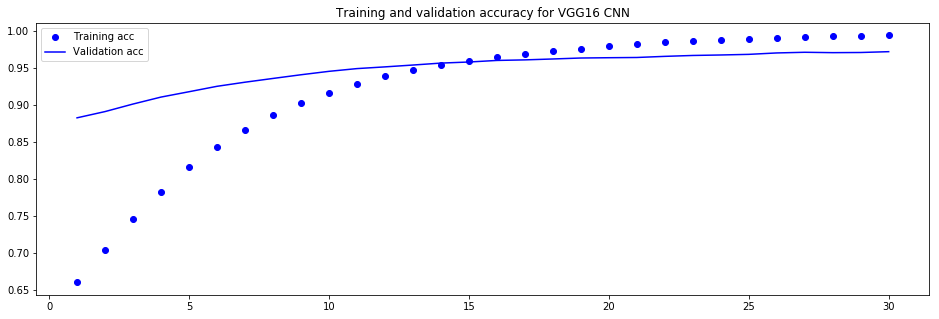

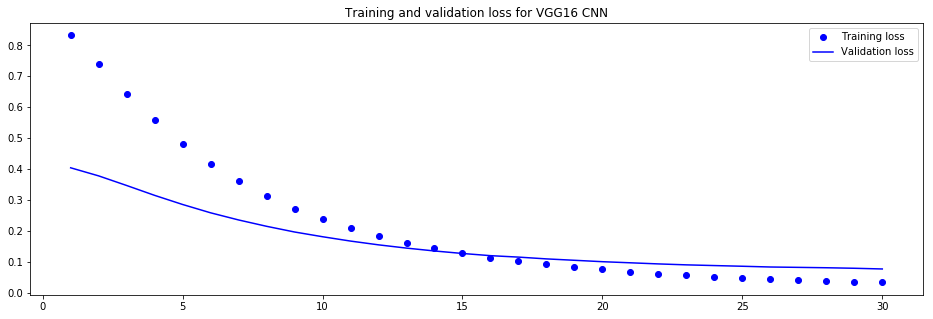

In [66]:
import matplotlib.pyplot as plt

def get_plots():
    
    smooth=True
    
    loss=[0.8322 ,0.3657 ,0.2651 ,0.2119 ,0.1816 ,0.1555 ,0.1353 ,0.1229 ,0.1121 ,0.1023 ,0.0917 ,0.0834 ,0.0785 ,0.0722 ,0.0641 ,0.0589 ,0.0580 ,0.0565 ,0.0482 ,0.0438 ,0.0410 ,0.0377 ,0.0386 ,0.0350 ,0.0326 ,0.0298 ,0.0280 ,0.0295 ,0.0263 ,0.0247]
    
    acc=[0.6604 ,0.8775 ,0.9152 ,0.9319 ,0.9459 ,0.9545 ,0.9607 ,0.9642 ,0.9658 ,0.9728 ,0.9767 ,0.9809 ,0.9790 ,0.9833 ,0.9833 ,0.9856 ,0.9868 ,0.9876 ,0.9891 ,0.9930 ,0.9942 ,0.9934 ,0.9918 ,0.9949 ,0.9938 ,0.9981 ,0.9973 ,0.9949 ,0.9969 ,0.9969]
  
    val_loss=[0.4046 ,0.2740 ,0.2234 ,0.1881 ,0.1683 ,0.1517 ,0.1439 ,0.1338 ,0.1237 ,0.1209 ,0.1119 ,0.1071 ,0.1032 ,0.0991 ,0.0956 ,0.0926 ,0.0976 ,0.0874 ,0.0880 ,0.0832 ,0.0836 ,0.0798 ,0.0790 ,0.0798 ,0.0778 ,0.0746 ,0.0784 ,0.0770 ,0.0735 ,0.0688]
    
    val_acc=[0.8828,0.9250,0.9422,0.9484,0.9469,0.9547,0.9531,0.9563,0.9609,0.9641,0.9641,0.9609,0.9641,0.9672,0.9641,0.9688,0.9641,0.9672,0.9688,0.9656,0.9656,0.9719,0.9719,0.9703,0.9719,0.9781,0.9750,0.9688,0.9719,0.9766]
    

    
#     val_acc=[0.8828,0.925,0.9422,0.9484,0.9469,0.9547,0.9531,0.9563,0.9609,0.9641,0.9641,0.9609,0.9641,0.9672,0.9641,0.9688,0.9641,0.9672,0.9688,0.9656,0.9656,0.9719,0.9719,0.9703,0.9719,0.9781,0.975,0.9688,0.9719,0.9766]
 
#     val_acc=[0.4406,0.5797,0.6219,0.6344,0.6859,0.7437,0.7875,0.8047,0.8062,0.8172,0.8328,0.8531,0.8578,0.8375,0.8703,0.8766,0.8750,0.8828,0.8844,0.8875,0.8766,0.8859,0.9000,0.8906,0.8938,0.9047,0.9094,0.9172,0.9234,0.9109]
#     val_loss=[1.2140, 1.0124, 0.8743, 0.7908, 0.7212, 0.6398, 0.5663, 0.5221, 0.4846, 0.4517, 0.4252, 0.3975, 0.3825, 0.3924, 0.3564, 0.3371, 0.3243, 0.3153, 0.3078, 0.3032, 0.3168, 0.3053, 0.2707, 0.2857, 0.2684, 0.2551, 0.2482, 0.2353, 0.2277, 0.2416]
    epochs = [i for i in range(1, len(acc)+1)]
  
    if smooth == True:
        
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

#     print(len(acc))
#     print(len(epochs))

    acc=np.array(acc)
    val_acc=np.array(val_acc)
    loss=np.array(loss)
    val_loss=np.array(val_loss)
    
    acc1 = plt.figure().gca()
    acc1.set_title('Training and validation accuracy for VGG16 CNN')
    acc1.plot(epochs, acc, 'bo', label='Training acc')
    acc1.plot(epochs, val_acc,'b', label='Validation acc')
    
    acc1.legend()
    
#     acc.show()
    
    loss1 = plt.figure().gca()
    loss1.plot(epochs, loss, 'bo', label='Training loss')
    loss1.plot(epochs, val_loss, 'b', label='Validation loss')
    loss1.set_title('Training and validation loss for VGG16 CNN')
    loss1.legend()

    plt.show()
    
    
get_plots()

Instructions for updating:
Please use Model.predict, which supports generators.


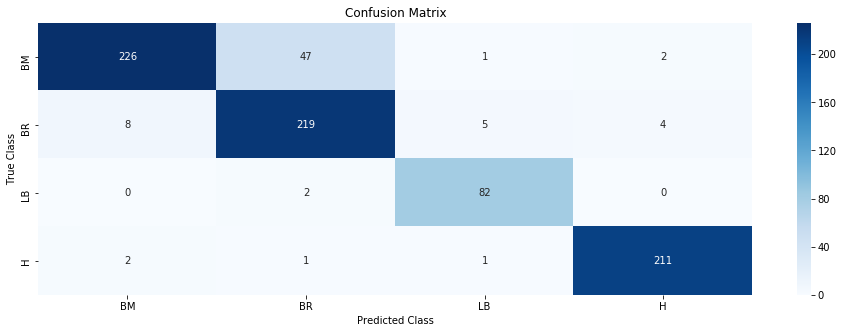

Classification Report
               precision    recall  f1-score   support

black_measles       0.96      0.82      0.88       276
    black_rot       0.81      0.93      0.87       236
  leaf_blight       0.92      0.98      0.95        84
      healthy       0.97      0.98      0.98       215

     accuracy                           0.91       811
    macro avg       0.92      0.93      0.92       811
 weighted avg       0.92      0.91      0.91       811



In [15]:
from models import vanilla,vgg16
saved_model = './trained_models/vanilla.h5'
model = vanilla.VanillaCNN()
model.evaluate(saved_model, data['test'], data['num_test'], name=None)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

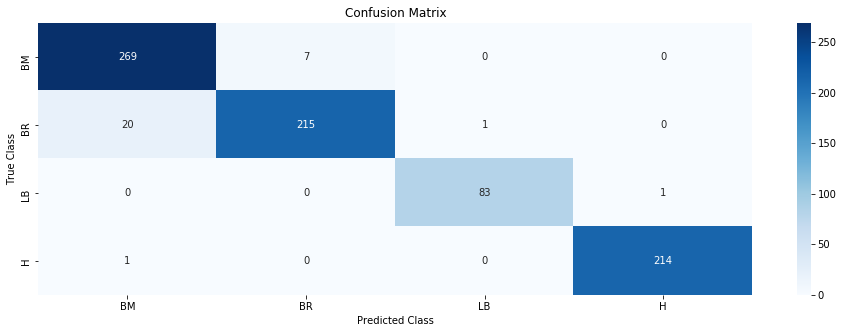

Classification Report
               precision    recall  f1-score   support

black_measles       0.93      0.97      0.95       276
    black_rot       0.97      0.91      0.94       236
  leaf_blight       0.99      0.99      0.99        84
      healthy       1.00      1.00      1.00       215

     accuracy                           0.96       811
    macro avg       0.97      0.97      0.97       811
 weighted avg       0.96      0.96      0.96       811



In [16]:
saved_model = './trained_models/vgg16.h5'
model = vgg16.VGG16()
model.evaluate(saved_model, data['test'], data['num_test'], name=None)